In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

from EffP import *
from QLPDCgen import *
from PLmatrix_CSS import *

In [2]:
from numpy.linalg import matrix_power
from numpy.linalg import matrix_rank

## adapted from: stackoverflow...
def gf2_rank(rows):
    """
    Find rank of a matrix over GF2.
    The rows of the matrix are given as nonnegative integers, thought
    of as bit-strings.
    This function modifies the input list. Use gf2_rank(rows.copy())
    instead of gf2_rank(rows) to avoid modifying rows.
    """
    rows_new = []
    rank = 0
    while rows:
        #print(rows)
        pivot_row = rows.pop()
        #print(pivot_row)
        if pivot_row:
            rows_new.append(pivot_row)
            rank += 1
            lsb = pivot_row & -pivot_row
            for index, row in enumerate(rows):
                if row & lsb:
                    rows[index] = row ^ pivot_row
    return (rows_new, rank)

## transform back to the binary matrix:
def Hb_to_H(n,r,H_list):
    H_tot = []
    for i in range(r):
        H_row = []
        H_num = H_list[i]
        for k in range(n-1,-1,-1):
            H_row.append(H_num // (2**k))
            H_num = H_num % (2**k)
        H_tot.append(H_row)
    H_new = np.array(H_tot)
    return H_new

def GB_gen(l,a_l,b_l):
    P_l = np.zeros((l,l),dtype=int)
    P_l[0,l-1] = 1
    P_l[1:l,0:l-1] = np.eye(l-1, dtype=int)
    A_part = np.eye(l, dtype=int)
    B_part = np.eye(l, dtype=int)
    for k_l in a_l:
        A_part += matrix_power(P_l,k_l)
    for k_l in b_l:
        B_part += matrix_power(P_l,k_l)
    A_part = A_part % 2
    B_part = B_part % 2
    H_X = np.concatenate((A_part, B_part), axis=1)
    H_Z = np.concatenate((np.transpose(B_part), np.transpose(A_part)), axis=1)
    H_XZ = np.zeros((2*l,4*l), dtype = int)
    H_XZ[0:l, 0:2*l] = H_X
    H_XZ[l:2*l, 2*l:4*l] = H_Z
    return H_XZ

### [[48, 6, 8]] code

In [100]:
l=24
n = 48
k = 6
r = 21
H_XZ = GB_gen(l,[2,8,15],[2,12,17])

### [[46, 2, 9]] code

In [2]:
l=23
n = 46
k = 2
r = 22
H_XZ = GB_gen(l,[5,8,12],[1,5,7])

### [126, 28, 8] code

In [210]:
l=63
n = 126
k = 28
r = 49
H_XZ = GB_gen(l,[1,14,16,22],[3,13,20,42])


### [900, 50, 15] code

In [151]:
l=450
n = 900
k = 50
r = 425
H_XZ = GB_gen(l,[97,372,425],[50,265,390])

In [3]:
Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
Sz_mat = H_XZ[:, n:]
Sz_mat = Sz_mat[~np.all(Sz_mat == 0, axis=1)]
print(Sx_mat.shape,Sz_mat.shape)
print(np.linalg.norm(Sx_mat@Sz_mat.T %2))

from ldpc.mod2 import rank,row_basis,inverse
# print(row_basis(Sx_mat).shape)
Sx_mat = row_basis(Sx_mat)
Sz_mat = row_basis(Sz_mat)
print(Sx_mat.shape,Sz_mat.shape)
print(np.linalg.norm(Sx_mat@Sz_mat.T %2))


(23, 46) (23, 46)
0.0
(22, 46) (22, 46)
0.0


## daoheng's code

In [195]:
##########
H_X = H_XZ[:, 0:n]
H_X = H_X[~np.all(H_X == 0, axis=1)]
H_Z = H_XZ[:, n:2*n]
H_Z = H_Z[~np.all(H_Z == 0, axis=1)]
print(H_X.shape, H_Z.shape)
n_row = np.size(H_X,axis=0)
H_Xb = []
H_Zb = []
for i_r in range(n_row):
    H_Xb.append(np.sum(H_X[i_r,:]* 2**np.arange(n-1,-1,-1)))
    H_Zb.append(np.sum(H_Z[i_r,:]* 2**np.arange(n-1,-1,-1)))

H_Xbc = H_Xb.copy()
H_Zbc = H_Zb.copy()
H_Xb1, RoX = gf2_rank(H_Xbc)
H_Zb1, RoZ = gf2_rank(H_Zbc)

print(len(H_Xb1),len(H_Zb1))

H_X_new = Hb_to_H(n,r,H_Xb1)
H_Z_new = Hb_to_H(n,r,H_Zb1)
H_XZ = np.zeros((2*r,4*l), dtype = int)
H_XZ[0:r, 0:2*l] = H_X_new
H_XZ[r:2*r, 2*l:4*l] = H_Z_new

Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
Sz_mat = H_XZ[:, n:2*n]
Sz_mat = Sz_mat[~np.all(Sz_mat == 0, axis=1)]
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer
# print("Ns=%d, Nq=%d" % (Ns_l,Nq_l))
print(Sx_mat.shape,Sz_mat.shape)
print(np.linalg.norm(Sx_mat@Sz_mat.T %2))
# logicals_X = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[0]
# logicals_Z = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[1]
# logical_tX = logicals_X[:,0:Nq_l]
# logical_tZ = logicals_Z[:,Nq_l:2*Nq_l]
##########################################

# print("X weight: ", np.sum(logicals_Z,axis=1))
# print("Z weight: ", np.sum(logicals_X,axis=1))

# print( np.linalg.norm((Sx_mat@logical_tZ.T) % 2))
# print( np.linalg.norm((Sz_mat@logical_tX.T) % 2))

(23, 46) (23, 46)
22 22
(22, 46) (22, 46)
0.0


In [4]:
from ldpc.codes import hamming_code
from bposd.css import css_code

qcode=css_code(hx=Sx_mat,hz=Sz_mat)

# print(qcode.hx)
# print(qcode.hz)

lx=qcode.lx #x logical operators
lz=qcode.lz #z logical operators
print("X weight: ", np.sum(lx,axis=1))
print("Z weight: ", np.sum(lz,axis=1))

# lx[1,:] = (lx[1,:]+lx[0,:])%2
lz[0,:] = (lz[1,:]+lz[0,:])%2
# lz[3,:] = (lz[3,:]+lz[0,:])%2
# lz[5,:] = (lz[5,:]+lz[2,:]+lz[0,:])%2


# print(qcode.compute_code_distance())
# temp=inverse(lx@lz.T %2)
# lx=temp@lx %2
    
print(lx.shape,lz.shape)

print( (lz@lx.T)% 2)
# print(lz)
print( np.linalg.norm((Sx_mat@Sz_mat.T) % 2))
print( np.linalg.norm((Sz_mat@lx.T) % 2))
print( np.linalg.norm((Sx_mat@lz.T) % 2))

print("X weight: ", np.sum(lx,axis=1))
print("Z weight: ", np.sum(lz,axis=1))

X weight:  [23 10]
Z weight:  [23 15]
(2, 46) (2, 46)
[[1 0]
 [0 1]]
0.0
0.0
0.0
X weight:  [23 10]
Z weight:  [10 15]


In [13]:
print(lz@logical_tX.T %2)
print(lx@logical_tZ.T %2)

[[0 0 1 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 0 0 0]
 [1 0 0 1 1 0]
 [0 1 1 0 1 0]
 [1 0 1 1 0 0]]
[[0 1 1 0 1 1]
 [0 0 1 0 0 1]
 [1 0 0 1 0 0]
 [0 1 1 0 1 1]
 [1 0 1 1 0 0]
 [1 0 0 1 0 0]]


In [25]:
def succ_prob_css_q_resolved_2(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: list of numpy arrays]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    N = np.size(logicals_in,1)
    B = B_orig.copy()
    logicals = np.copy(logicals_in)
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    N_logic = np.size(logicals_in,0)
    logic_list = np.ones(N_logic)
    for i_q, q in enumerate(loss_inds):
        ## correct logical operators
        logic_remained = np.argwhere(logic_list==1)[:,0]
        # print(logic_remained)
        # print(np.shape(logicals))
        # print(logicals[logic_remained])
        logic_removed,logic_modified, logic_op = correct_logical_q_resolved(q,logicals[logic_remained,:], Sx_mat)
        logic_list[logic_remained[logic_removed]] = 0
        if len(logic_modified)>0:
            logicals[logic_remained[logic_modified],:] = np.array(logic_op)
        ## update stabilizer group
        ## first: update graph
        if q in B:
            B, s_nodes_set = modify_graph(q,B,s_nodes_set)
        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                # break
    
    return logic_list

def correct_logical_q_resolved(q,logicals_in, Sx_mat):
    logicals = list(np.copy(logicals_in))
    logic_removed = []
    Ns_remain = np.size(Sx_mat,0)
    if len(logicals) == 1:
        if logicals[0][q]>0:
            if Ns_remain> 0:
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
                else:
                    logicals.pop()
                    logic_removed.append(0)
            else:
                logicals.pop()
                logic_removed.append(0)

    else:
        for i_log in np.arange(len(logicals)-1,-1,-1):
            if logicals[i_log][q]>0:
                if Ns_remain> 0:
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logicals.pop(i_log)
                        logic_removed.append(i_log)
                else:
                    logicals.pop(i_log) 
                    logic_removed.append(i_log)
                    
    logic_modified = list(set(range(len(logicals)))-set(logic_removed))
    return logic_removed,logic_modified, logicals


    

In [5]:
## with logical operator

logical_tZ = lz
logical_tX = lx
N_logic = np.size(logical_tZ,0)
N = np.size(Sx_mat,1) # number of data qubits 
Ns = np.size(Sx_mat,0) # number of stabilizers 

## construct stabilizer graph
B_orig_X = nx.Graph()
B_orig_X.add_nodes_from(np.arange(N))
B_orig_Z = nx.Graph()
B_orig_Z.add_nodes_from(np.arange(N))
s_nodes = ["s%d" % s for s in np.arange(Ns)]
B_orig_X.add_nodes_from(s_nodes)
B_orig_Z.add_nodes_from(s_nodes)

for row in range(Ns):
    qs_X = np.argwhere(Sx_mat[row,:]>0)[:,0]
    B_orig_X.add_edges_from([("s%d" % row, q) for q in qs_X])
    qs_Z = np.argwhere(Sz_mat[row,:]>0)[:,0]
    B_orig_Z.add_edges_from([("s%d" % row, q) for q in qs_Z])

# nx.draw(B_orig_X,  with_labels=True)
# plt.show()

p_list = np.linspace(0.01,0.99,20)
Nrep = 100# number of MC iterations
succ_prob_X = np.zeros((len(p_list),np.size(logical_tX,0)))
succ_prob_Z = np.zeros((len(p_list),np.size(logical_tX,0)))
succ_prob_word = np.zeros(len(p_list))
tic = time.time()
for i_p, p in enumerate(p_list):
    for i_rep in range(Nrep):
        loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
        # succ_prob_X[i_p] += succ_prob_css_calc(B_orig_X, logical_tX, s_nodes, loss_inds)
        # succ_prob_Z[i_p] += succ_prob_css_calc(B_orig_Z, logical_tZ, s_nodes, loss_inds)
        succ_prob_X_val = succ_prob_css_q_resolved(B_orig_X, logical_tX, s_nodes, loss_inds)
        succ_prob_X[i_p,:] += succ_prob_X_val
        succ_prob_Z_val = succ_prob_css_q_resolved(B_orig_Z, logical_tZ, s_nodes, loss_inds)
        succ_prob_Z[i_p,:] += succ_prob_Z_val
        if np.sum(succ_prob_Z_val)== N_logic and np.sum(succ_prob_X_val)== N_logic:
            succ_prob_word[i_p] += 1

toc = time.time()
print("Elapsed time %d sec." % (toc-tic))
succ_prob_X /= Nrep
succ_prob_Z /= Nrep
succ_prob_word /= Nrep

Elapsed time 61 sec.


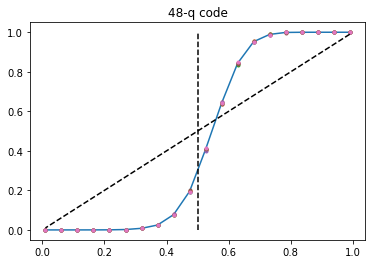

In [121]:
# plt.plot(1-p_list,succ_prob_X,"o",label="X")
# plt.plot(1-p_list,succ_prob_Z,"x",label="Z")

succ_prob = succ_prob_X*succ_prob_Z
succ_prob_avg = np.mean(succ_prob,axis=1)
s_err = np.std(succ_prob,axis=1)/8**0.5
# print(s_err/succ_prob_avg)
# s_err = (succ_prob_avg*(1-succ_prob_avg)/8)**0.5
# print(s_err/succ_prob_avg)
# xzerr = ((xerr/succ_prob_X_avg)**2+(zerr/succ_prob_Z_avg)**2)**0.5* succ_prob_avg

plt.plot(1-p_list,succ_prob_avg)
plt.plot(1-p_list,succ_prob,".")
# plt.fill_between(1-p_list,np.amin(succ_prob,axis=1),np.amax(succ_prob,axis=1), alpha=0.5)


# plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
# f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
# plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("48-q code")
# plt.legend()
plt.show()

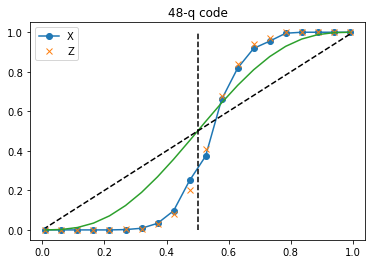

In [52]:
plt.plot(1-p_list,succ_prob_X,"o-",label="X")
plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("48-q code")
plt.legend()
plt.show()

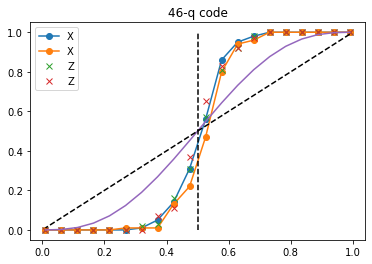

In [29]:
plt.plot(1-p_list,succ_prob_X,"o-",label="X")
plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("46-q code")
plt.legend()
plt.show()

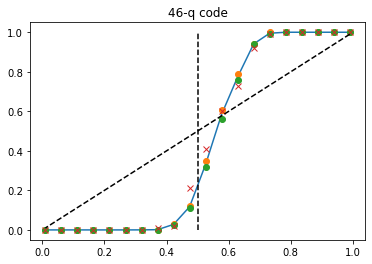

In [6]:
# plt.plot(1-p_list,succ_prob_X,"o",label="X")
# plt.plot(1-p_list,succ_prob_Z,"x",label="Z")

succ_prob = succ_prob_X*succ_prob_Z
succ_prob_avg = np.mean(succ_prob,axis=1)
s_err = np.std(succ_prob,axis=1)/8**0.5
# print(s_err/succ_prob_avg)
# s_err = (succ_prob_avg*(1-succ_prob_avg)/8)**0.5
# print(s_err/succ_prob_avg)
# xzerr = ((xerr/succ_prob_X_avg)**2+(zerr/succ_prob_Z_avg)**2)**0.5* succ_prob_avg

plt.plot(1-p_list,succ_prob_avg)
plt.plot(1-p_list,succ_prob,"o")
plt.plot(1-p_list,succ_prob_word,"x")
# plt.fill_between(1-p_list,np.amin(succ_prob,axis=1),np.amax(succ_prob,axis=1), alpha=0.5)


# plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
# f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
# plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("46-q code")
# plt.legend()
plt.show()

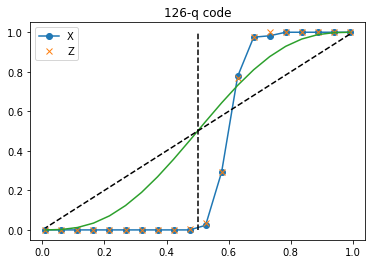

In [209]:
plt.plot(1-p_list,succ_prob_X,"o-",label="X")
plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("126-q code")
plt.legend()
plt.show()

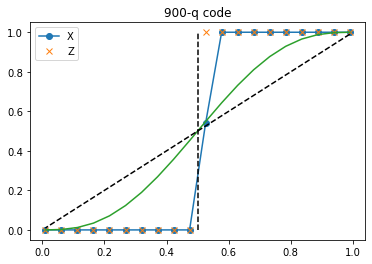

In [155]:
plt.plot(1-p_list,succ_prob_X,"o-",label="X")
plt.plot(1-p_list,succ_prob_Z,"x",label="Z")
f = lambda x: x**5 + 5* x**4* (1-x) + 5*2*x**3 * (1-x)**2
plt.plot(1-p_list,f(1-p_list),"-")
plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-1/2
plt.plot([x0,x0],[0,1],"k--")
plt.title("900-q code")
plt.legend()
plt.show()